* Check if 10.5 m is deep enough to trap the plume according to the plume threshold.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import DetermineEdgePlume as DEP
import R_mixStuff as RS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
sites = {'Sandheads': {'lat': 49.10,'lon': -123.30,'j' : 46,'i' : 53},
        'NS':{'lat':49.17,'lon':-123.30,'j': 60,'i':61},
        'WS':{'lat':49.11,'lon':-123.40,'j': 53,'i':38}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [4]:
## load grid_T model results
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')

In [5]:
def Extract_Salinity(grid_T,stn,tst,ted,dep):
    """
    Extract salinity at a single depth at a station, in order to plot the histogram
    """
    S = grid_T.variables['vosaline']
    S_Extract= S[tst:ted+1,dep,sites[stn]['j'],sites[stn]['i']]

    return S_Extract

In [6]:
S_jan = Extract_Salinity(janall_T,'NS',0,743,10)
S_oct = Extract_Salinity(octall_T,'NS',0,743,10)
S_may = Extract_Salinity(mayall_T,'NS',0,743,10)

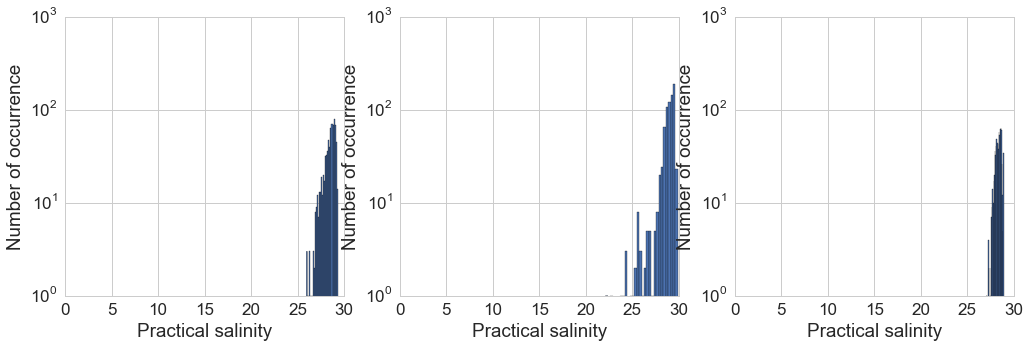

In [7]:
fig,axs = plt.subplots(1,3,figsize = (17,5))
ax = axs[0]
ax.hist(S_jan,bins = 30)
ax = axs[1]
ax.hist(S_oct,bins = 30)
ax = axs[2]
ax.hist(S_may,bins = 30)
for ax in axs.flatten():
    ax.set_ylim([1e0,1e3])
    ax.set_yscale('log')
    ax.set_xlim([0,30])
    ax.set_xlabel('Practical salinity')
    ax.set_ylabel('Number of occurrence')
plt.show()